# 🧠 T5 Small on SQL-Create-Context (Seq2Seq QA)

This notebook fine-tunes **T5-Small** to answer questions given a short SQL/table context, and evaluates with **SacreBLEU**.  
You’ll see: dataset loading, preprocessing, training with `Seq2SeqTrainer`, metric computation, charts, and an inference demo.


In [ ]:
import json
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments,set_seed
import torch
import os
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
import numpy as np
import evaluate



## 🔁 Reproducibility
We fix random seeds to make runs comparable.

In [40]:
set_seed(42)

## 📦 Dataset & Metrics
- **Dataset**: `b-mc2/sql-create-context` (Hugging Face Datasets)
- **Metric**: `sacrebleu` (BLEU-1..4 + overall BLEU)
- **Output dir**: `./results` for checkpoints and logs

In [2]:
ds_path = r"b-mc2/sql-create-context"
OUTPUT_DIR = "./results"
bleu = evaluate.load("sacrebleu") 

Using the latest cached version of the module from C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--sacrebleu\28676bf65b4f88b276df566e48e603732d0b4afd237603ebdf92acaacf5be99b (last modified on Sat Sep 13 22:21:52 2025) since it couldn't be found locally at evaluate-metric--sacrebleu, or remotely on the Hugging Face Hub.


## 📂 Train/Test Split Helper
`load_datasets(ds_path)` loads the dataset and performs an 80/20 split with a fixed seed.

In [59]:
def load_datasets(ds_path):
    ds = load_dataset(ds_path)

    # # Convert list of dicts to HuggingFace Dataset
    ds = ds["train"].train_test_split(test_size=0.2, seed=42)
    print(len(ds['train']), len(ds['test']))

    return ds["train"], ds["test"]

## ✍️ Preprocessing & Tokenization
We build T5 inputs in the pattern:

In [5]:
def preprocess_function(examples, max_input_length = 512, max_target_length = 64):
  inputs = ["question: " + q + " context: " + c for q, c in zip(examples["question"], examples["context"])]
  targets = examples["answer"]
  model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

  with tokenizer.as_target_tokenizer():
      labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding="max_length")

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

## 📏 Evaluation: SacreBLEU
`compute_metrics` decodes predictions/labels and computes BLEU.
- BLEU-1..4 show n-gram precision for longer phrases.
- Higher is better; 0–100 scale (SacreBLEU returns 0–100 here).


In [62]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    
    # Decode predictions
    print(preds)
    preds = [
        [(x if x != -100 else tokenizer.pad_token_id) for x in pd]
        for pd in preds
    ]


    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    print(decoded_preds,   tokenizer.batch_decode(labels, skip_special_tokens=True))
    print("====")
    # Replace -100 with pad_token_id in labels
    labels = [
        [(x if x != -100 else tokenizer.pad_token_id) for x in lab]
        for lab in labels
    ]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Strip and shape properly
    hyps = [p.strip() for p in decoded_preds]
    refs = [[lbl.strip()] for lbl in decoded_labels]  # sacrebleu expects list[list[str]]

    # Compute BLEU
    res = bleu.compute(predictions=hyps, references=refs, tokenize="zh")

    # Precisions are percentages, normalize if needed
    p1, p2, p3, p4 = res["precisions"]

    return {
        "bleu": res["score"],      # main BLEU score
        "bleu-1": p1,              # unigram precision
        "bleu-2": p2,              # bigram precision
        "bleu-3": p3,              # trigram precision
        "bleu-4": p4,              # 4-gram precision
    }

## 🏋️ Training Configuration
We use `Seq2SeqTrainer` with:
- `eval_strategy="steps"` and `eval_steps=500`
- Checkpointing every 500 steps (`save_steps`)
- Learning rate ~ `3e-5` (tunable)
This block returns a configured `trainer`.

In [63]:
def set_up_trainer(max_target_length, tokenized_train,tokenized_test, model, tokenizer ):
    training_args = Seq2SeqTrainingArguments(
        output_dir="./results",
        eval_strategy="steps",
        eval_steps=500,                 # less frequent than with tiny data
        save_strategy="steps",
        save_steps=500,
        save_total_limit=2,

        learning_rate=3e-5,             # safer than 5e-5 for longer training
        per_device_train_batch_size=16, # if GPU allows; else 8
        per_device_eval_batch_size=16,
        weight_decay=0.01,
        num_train_epochs=5,             # usually enough; can go 3–5
        warmup_steps=500,               # scale with dataset size

        predict_with_generate=True,
        generation_max_length=max_target_length,
        logging_dir="./logs",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="bleu",   # or rouge
        greater_is_better=True
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    return trainer

## 📊 Training Curves
Helper to extract `trainer.state.log_history` and plot:
- Training loss vs. steps/epochs
- Evaluation loss vs. steps
Optionally extend to plot BLEU over time.

In [57]:
def evaluate_chart(trainer):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    train_epoch, train_loss = [], []
    eval_steps,  eval_loss  = [], []

    for log in trainer.state.log_history:
        if "loss" in log and "learning_rate" in log:
            train_epoch.append(log["epoch"])
            train_loss.append(log["loss"])
            print(log["loss"])
        if "eval_loss" in log:
            eval_steps.append(log["epoch"])
            eval_loss.append(log["eval_loss"])

    plt.figure(figsize=(7,5))
    if train_epoch: 
        plt.plot(train_epoch, train_loss, label="train_loss")
    if eval_steps:  
        plt.plot(eval_steps,  eval_loss,  label="eval_loss")

    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Convergence Curve")
    plt.legend()
    plt.tight_layout()

    # 保存
    plt.savefig(os.path.join(OUTPUT_DIR, "loss_curve.png"))

    # 显示
    plt.show()

    # 关闭
    plt.close()

## 🚀 End-to-End Run
**Steps**
1. Load tokenizer/model: `T5-Small`
2. Load & split dataset
3. Tokenize train/test
4. Build trainer (`Seq2SeqTrainer`)
5. Train with periodic evaluation
6. Save model & tokenizer

In [64]:
if __name__ == "__main__":
    # Load tokenizer & model
    model_name = "T5-Small"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    # Load train, test, and dev datasets from the given JSONL files 
    train_dataset, test_dataset = load_datasets(ds_path)

    #tokenize train, test, dev dataset
    max_input_length = 512
    max_target_length = 64
    tokenized_train = train_dataset.map(preprocess_function, batched=True)
    tokenized_test = test_dataset.map(preprocess_function, batched=True)


    # #train the model
   
    trainer = set_up_trainer(max_target_length, tokenized_train.select(range(6000)),tokenized_test.select(range(1500)), model, tokenizer )
    trainer.train()

    #evalate the model
    results = trainer.evaluate()

    

Using the latest cached version of the dataset since b-mc2/sql-create-context couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\User\.cache\huggingface\datasets\b-mc2___sql-create-context\default\0.0.0\9d80a6a118b838d9defc3798d659a54a2ac2ff37 (last modified on Sun Sep 14 11:16:41 2025).


62861 15716


C:\Users\User\AppData\Local\Temp\ipykernel_29512\2336398805.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss,Bleu,Bleu-1,Bleu-2,Bleu-3,Bleu-4
500,0.380700,0.251642,71.684449,87.172052,76.561817,71.848286,67.497548
1000,0.215000,0.162785,78.178723,90.402940,81.950222,78.100364,74.561968
1500,0.195100,0.142407,80.797671,92.020443,84.825853,81.256167,77.975855


[[    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]
 ...
 [    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]]
['SELECT venue FROM table_name_50 WHERE away_team = "essendon"', 'SELECT game FROM table_name_61 WHERE opponent = "magnitude" AND record = "29-17"', 'SELECT Texan FROM table_name_37 WHERE week = "4"', 'SELECT points FROM table_name_70 WHERE touchdowns = "0" AND extra_points = "0"', 'SELECT name FROM table_name_83 WHERE moving_to = "greenock morton"', 'SELECT contestants FROM votes (contestant_number) AND contestant_name = "the contestant who got least votes"', 'SELECT venue FROM table_name_50 WHERE result = "7-1"', 'SELECT tournament FROM table_name_22 WHERE tournament = "45"', 'SELECT state FROM college WHERE enr INTEGER', 'SELECT title FROM table_24648983_1 WHERE us_viewers__million_ = "9.89 million"', 'SELECT Workshop_Group

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[[    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]
 ...
 [    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]
 [    0     3 23143 ...  -100  -100  -100]]
['SELECT venue FROM table_name_50 WHERE away_team = "essendon"', 'SELECT MIN(game) FROM table_name_61 WHERE opponent = "pax" AND record = "29-17"', 'SELECT opponent FROM table_name_37 WHERE week = 4', 'SELECT COUNT(points) FROM table_name_70 WHERE touchdowns = "0" AND extra_points  0', 'SELECT name FROM table_name_83 WHERE moving_to = "scot" AND transfer_window = "greenock morton"', 'SELECT contestants FROM votes WHERE contestant_number = "low" AND contestant_name = "the contestant who got voted"', 'SELECT venue FROM table_name_50 WHERE result = "7-1"', 'SELECT tournament FROM table_name_22 WHERE 1945 = "a" AND 1949', 'SELECT state FROM college WHERE enr INTEGER', 'SELECT title FROM table_24648983_1 WHERE us_viewers__million_ 

### ✅ Results Snapshot
Below we visualize training/evaluation loss and print BLEU metrics at evaluation checkpoints.

> Tip: Add your latest metrics table (e.g., Step, Train/Val Loss, BLEU-1..4) here so readers see the final numbers at a glance.


13.0773
6.0432
1.5948
0.5935
0.3807
0.3138
0.2687
0.273
0.2379
0.215
0.2218
0.2079
0.1942
0.1962
0.1951
0.1853
0.1906
0.1892


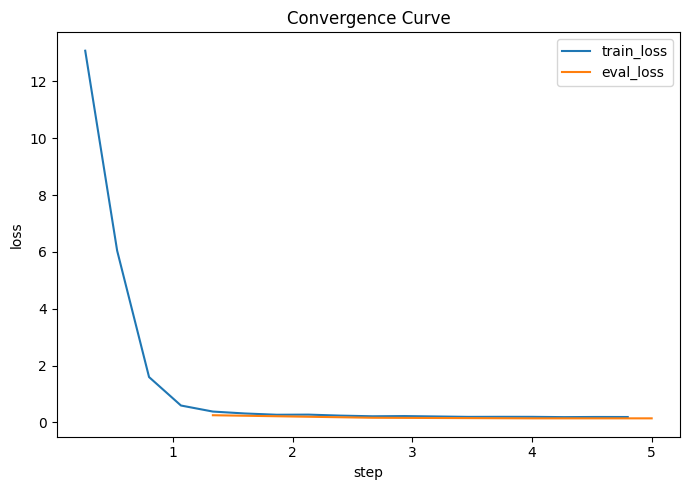

In [65]:
evaluate_chart(trainer)

## 🔮 Inference Demo
Minimal example of formatting a single query + context, running `model.generate`, and decoding the answer.

**Template**

In [ ]:
context = "CREATE TABLE head (age INTEGER)"
query = "How many heads of the departments are older than 56 ?"


input_text = f"question: {query}  context: {context}"

inputs = tokenizer(
    input_text,
    return_tensors="pt",       \
    max_length=512,
    truncation=True
).to("cuda")

outputs = model.generate(
    **inputs,
    max_length=64,            
    num_beams=4,                
    early_stopping=True
)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("生成答案:", answer)

生成答案: SELECT COUNT(age) FROM head WHERE age = 56
